In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import math
from qutip import *
from qutip.ipynbtools import plot_animation
import numpy as np
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display, Math, Latex

In [2]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0, stop=1, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = cm.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [5]:
xvec = np.arange(-40.,40.)*5./40
X,Y = np.meshgrid(xvec, xvec)  ##Some plotting params
N_dim = 9 ##Dimenstion of the Hilbert space
#amp =0.707*(1+1j) ## Coherent state
#amp =  1.732*(1+1j)
amp = 1*(1+1j)
#amp=np.sqrt(3/2)*(1+1j)
a1 = destroy(N_dim) ##Lowering operator 
a2 = destroy(N_dim) ##Lowering operator 
a3 = destroy(N_dim) ##Lowering operator 
Fock_state = fock(N_dim, 1) ##single photon state
Fock_state_2 = fock(N_dim, 2) ##two photon state
Wigner_Fock_state = wigner(Fock_state,xvec,xvec)
'''Displacement Operator, takes a density matrix as input and outputs a density matrix displaced by alpha'''
def D(state,alpha):
    Rho_new=displace(N_dim,alpha)*state*displace(N_dim,alpha).dag()
    return Rho_new   
'''Define a rotation in phase space, or phase shifter operation'''
def Phase(theta):
    b=-1j*theta*a1.dag()*a1;
    return b.expm()
'''Squeezing operation, inputs a density matrix and outputs the squeezed density matrix for squeezing parameter r'''
def Sq(state,r):
    Rho_new=squeeze(N_dim,r)*state*squeeze(N_dim,r).dag();
    return Rho_new
'''The function below creates a beamsplitter operation that acts on two modes.  
The value for k determines what number Fock state could be filtered out of the first state
based on a single photon input for the second BS port, followed by single photon detection.'''
def BS_single_photon_filter(a1, a2, k):
    theta_k = np.arctan(np.sqrt(k))
    T = np.sin(theta_k)*np.sin(theta_k)
    R = np.cos(theta_k)*np.cos(theta_k)
    print('I am filtering', k, 'and:', theta_k*180/math.pi)
    print('BS T is : ', T, 'and : ', R)
    b = theta_k*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))
    return b.expm() ##expm() is Matrix exponential of quantum object.
def BS_50_50(a1,a2):
    b = (np.pi/4)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))
    return b.expm() ##expm() is Matrix exponential of quantum object.
def coherent_state_PDF(n, alpha): ##for later use when calculation probability distribution function
    mean_photon = abs(alpha)*abs(alpha)
    prob = math.exp(-mean_photon)*pow(mean_photon, n)/math.factorial(n)
    return prob, mean_photon
def fid_calc(psi_1, psi_2):
    fid = fidelity(psi_1, psi_2)
    return fid    
def cat_plus(alpha):
    cat = 0.707*(coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def cat_minus(alpha):
    cat = 0.707*(-coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
'''The fuction Fock_Filter takes an input state and filters out the |num> Fock state by applying the BS operator
to the initial state and a |1> state, followed by a projective measurement (single photon detection)
on the first output.  The normalized density matrix of the filtered state is then returned.'''
def Fock_Filter(in_state,num):
    Projector = tensor(Fock_state*Fock_state.dag(),qeye(N_dim));
    #Projector = tensor(qeye(N_dim),Fock_state*Fock_state.dag());
    #Initial_state=tensor(in_state,ket2dm(Fock_state));
    Initial_state=tensor(ket2dm(Fock_state),in_state);
    Rho=BS_single_photon_filter(a1,a2,num)*Initial_state*BS_single_photon_filter(a1,a2,num).dag();
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    #Rho_filtered = ((Rho*Projector).ptrace(0))/((Rho*Projector).tr())
    print('I am filtering out the |',num,'> state')
    return Rho_filtered
'''Now define a Fock Filter operation where instead of detecting a single photon and using a variable BS to filter out
n photons, detect n photons and use a 50:50 BS to filter out n photons!  Lets see if there is actually a difference'''
def Fock_Filter_50_50(in_state,num):
    Projector = tensor(fock(N_dim, num)*fock(N_dim, num).dag(),qeye(N_dim));
    #Projector = tensor(qeye(N_dim),fock(N_dim, num)*fock(N_dim, num).dag());
    #Initial_state=tensor(in_state,ket2dm(Fock_state));
    Initial_state=tensor(ket2dm(Fock_state),in_state);
    Rho=BS_50_50(a1,a2)*Initial_state*BS_50_50(a1,a2).dag();
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    #Rho_filtered = ((Rho*Projector).ptrace(0))/((Rho*Projector).tr())
    print('I am filtering out the |',num,'> state')
    return Rho_filtered
def Fock_Filter_50_50_prob(in_state,num):
    Projector = tensor(fock(N_dim, num)*fock(N_dim, num).dag(),qeye(N_dim));
    #Projector = tensor(qeye(N_dim),fock(N_dim, num)*fock(N_dim, num).dag());
    #Initial_state=tensor(in_state,ket2dm(Fock_state));
    Initial_state=tensor(ket2dm(Fock_state),in_state);
    Rho=BS_50_50(a1,a2)*Initial_state*BS_50_50(a1,a2).dag();
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    #Rho_filtered = ((Rho*Projector).ptrace(0))/((Rho*Projector).tr())
    print('I am filtering out the |',num,'> state')
    return Rho_filtered
def Fock_Filter_gen(in_state,refl,num,eta):
    Projector = tensor(fock(N_dim, num)*fock(N_dim, num).dag(),qeye(N_dim),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(Fock_state),ket2dm(fock(N_dim,0)));
    theta_loss = np.arcsin(np.sqrt(1-eta*eta));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag(),qeye(N_dim)) - tensor(a1.dag(),a2,qeye(N_dim)))).expm()
    BS_loss=(theta_loss*(tensor(a1,qeye(N_dim),a3.dag())-tensor(a1.dag(),qeye(N_dim),a3))).expm()
    
    Rho=BS1*Initial_state*BS1.dag();
    Rho2=BS_loss*Rho*BS_loss.dag();
    
    Rho_filtered = ((Rho2*Projector).ptrace(1))/((Rho2*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency',eta)
    return Rho_filtered

The probability of a sucessful detection is: 0.1111074218253962
I am filtering out the | 3 > state
fidelity with cat: 0.00854373868775118


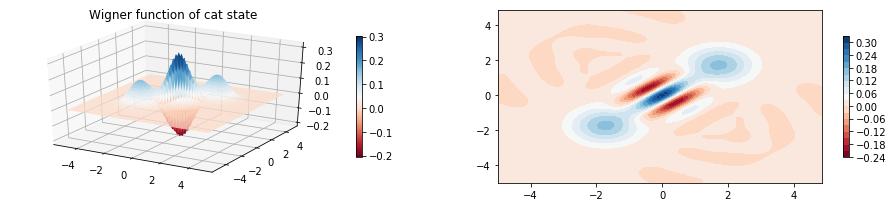

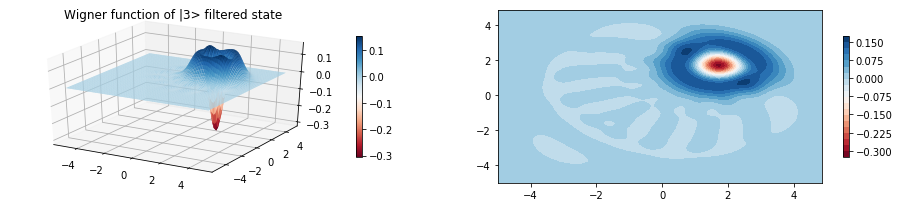

In [9]:
amp=np.sqrt(3)*(1+1j);
amp_cat=np.sqrt(3/2)*(1+1j)
cat=ket2dm(cat_plus(amp_cat));
#cat=ket2dm(Phase(np.pi/2)*cat_plus(amp_cat));
W_cat=wigner(cat,xvec,xvec);

first_5050=Fock_Filter_50_50_prob(ket2dm(coherent(N_dim,amp)),3)
W1=wigner(first_5050,xvec,xvec);

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_cat, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_cat, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of cat state')

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W1, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of |3> filtered state')
fid = fidelity(cat,first_5050)
print('fidelity with cat:',fid)


I am filtering out the | 1 > state
fidelity with cat: 0.3675966215060729


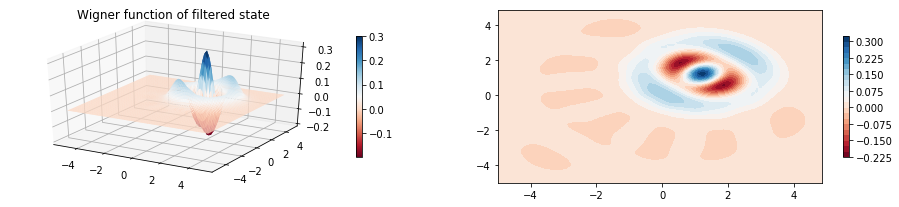

In [10]:
second_5050=Fock_Filter_50_50(first_5050,1);
W2=wigner(second_5050,xvec,xvec);

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W2, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of filtered state')
fid = fidelity(cat,second_5050)
print('fidelity with cat:',fid)
plt.show()


I am filtering 5 and: 65.90515744788931
BS T is :  0.8333333333333334 and :  0.16666666666666663
I am filtering 5 and: 65.90515744788931
BS T is :  0.8333333333333334 and :  0.16666666666666663
I am filtering out the | 5 > state
fidelity with cat: 0.42723097756321643


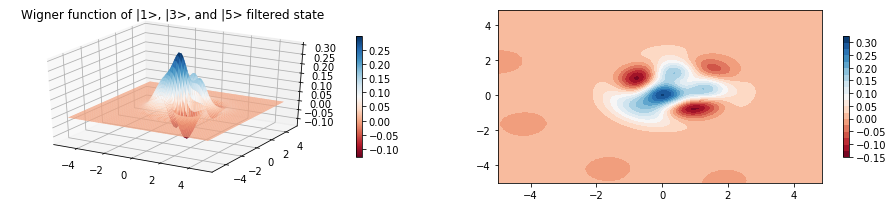

In [11]:
third_5050 = Fock_Filter(second_5050,5);
W3 = wigner(third_5050,xvec,xvec);


fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W3, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W3, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of |1>, |3>, and |5> filtered state')
fid = fidelity(cat,third_5050)
print('fidelity with cat:',fid)
plt.show()

fidelity with squeezed_cat: 0.9639772096717397


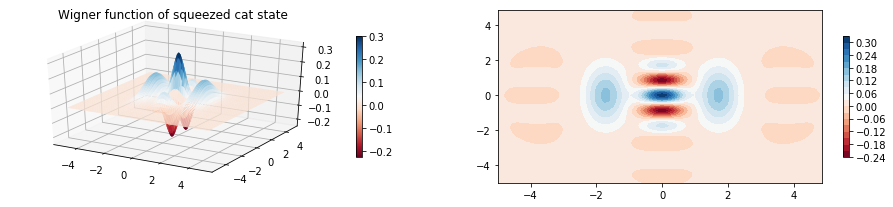

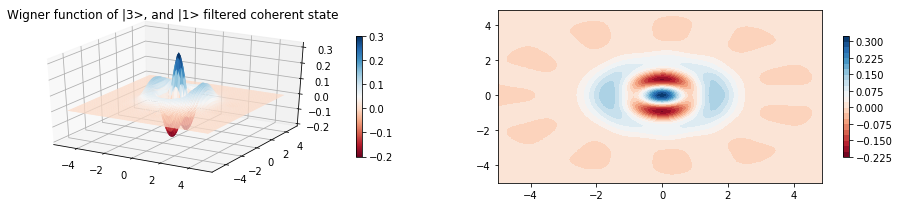

In [12]:
cat_amp=np.sqrt(2)*(1+1j)
#cat_test=Phase(-np.pi/4)*cat_minus(cat_amp)
#Wcat_test=wigner(cat_test,xvec,xvec)
cat_test=Phase(np.pi/4)*Sq(ket2dm(cat_plus(cat_amp)),.5j)*Phase(np.pi/4).dag()
Wcat_test=wigner(cat_test,xvec,xvec)
test_state=Sq(Phase(np.pi/4)*D(second_5050,np.sqrt(3/4)*(-1-1j))*Phase(np.pi/4).dag(),0)
W_test=wigner(test_state,xvec,xvec)


fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, Wcat_test, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Wcat_test, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of squeezed cat state')

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_test, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_test, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of |3>, and |1> filtered coherent state')
fid = fidelity(cat_test,test_state)
print('fidelity with squeezed_cat:',fid)
plt.show()

The probability of a sucessful detection is: 0.18393971863493838
I am filtering out the | 1 > state
fidelity with |1> fock state: 0.9999999943721326


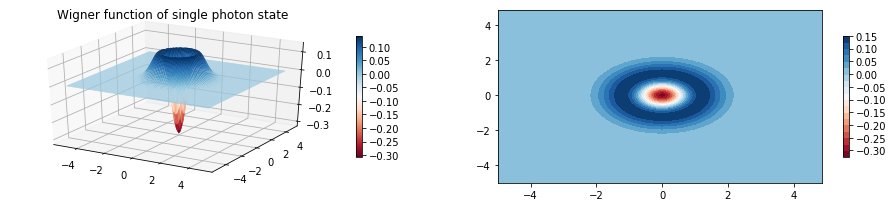

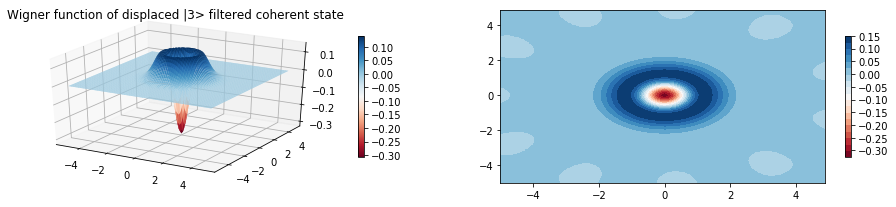

In [13]:
amp=np.sqrt(2)*(1);
cat_amp=np.sqrt(3)*(1+1j)
#cat_test=Phase(-np.pi/4)*cat_minus(cat_amp)
#Wcat_test=wigner(cat_test,xvec,xvec)

W_fock=wigner(fock(N_dim,1),xvec,xvec)
filtered=Fock_Filter_50_50_prob(ket2dm(coherent(N_dim,amp)),1)
test_state=D(filtered,np.sqrt(2/2)*(-1))
W_test=wigner(test_state,xvec,xvec)

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_fock, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_fock, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of single photon state')

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_test, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_test, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of displaced |3> filtered coherent state')
fid = fidelity(ket2dm(fock(N_dim,1)),test_state)
print('fidelity with |1> fock state:',fid)
plt.show()

I am filtering out the | 3 > state
I am filtering out the | 3 > state
The probability of a sucessful detection is: 0.11110742182539635
I am filtering out the | 3 > state
fidelity of state with displace fock state is: 0.9972632090931163


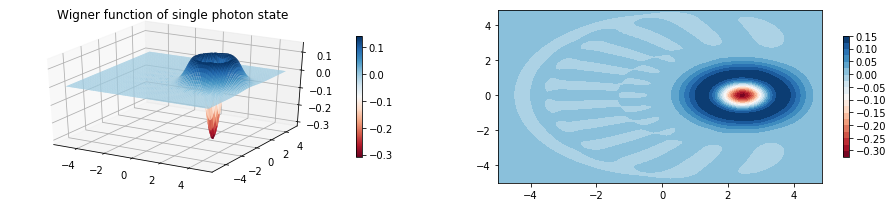

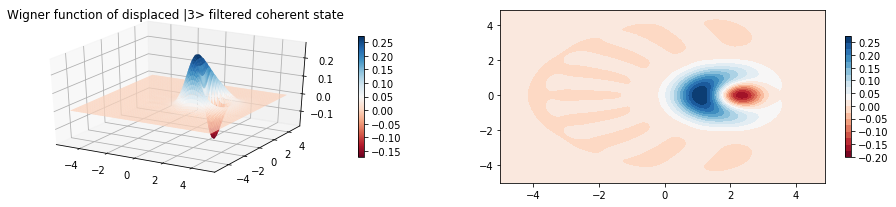

In [14]:
amp1=np.sqrt(4)*(1);
amp2=np.sqrt(5)*(1);
amp3=np.sqrt(6)*(1);
cat_amp=np.sqrt(3)*(1+1j)
#cat_test=Phase(-np.pi/4)*cat_minus(cat_amp)
#Wcat_test=wigner(cat_test,xvec,xvec)

Dis_fock=D(ket2dm(fock(N_dim,1)),amp3/np.sqrt(2))
W_dis=wigner(Dis_fock,xvec,xvec)
filtered1=Fock_Filter_50_50(ket2dm(coherent(N_dim,amp1)),3)
W_filter1=wigner(filtered1,xvec,xvec)
filtered2=Fock_Filter_50_50(ket2dm(coherent(N_dim,amp2)),3)
W_filter2=wigner(filtered2,xvec,xvec)
filtered3=Fock_Filter_50_50_prob(ket2dm(coherent(N_dim,amp3)),3)
W_filter3=wigner(filtered3,xvec,xvec)

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_dis, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_dis, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of single photon state')

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_filter1, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_filter1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of displaced |3> filtered coherent state')
fid=fidelity(Dis_fock,filtered3)
print('fidelity of state with displace fock state is:',fid)
plt.show()




In [4]:
eta=0.9
n=1
r_sq=1/2;
alpha=np.sqrt(n/r_sq)

amp1=np.sqrt(2/3)*alpha/eta;
amp2=np.sqrt(5/6)*alpha/eta;
amp3=alpha/eta;

#amp=np.sqrt(4);
disp_fock=D(ket2dm(fock(N_dim,1)),np.sqrt((amp*amp-n/(eta*eta))))
#dis_fock=D(ket2dm(fock(N_dim,1)),np.sqrt(2-1))
W_dis=wigner(disp_fock,xvec,xvec);


filtered_eta1=Fock_Filter_gen(ket2dm(coherent(N_dim,amp1)),r_sq,n,eta)
W_eta1=wigner(filtered_eta1,xvec,xvec);

filtered_eta2=Fock_Filter_gen(ket2dm(coherent(N_dim,amp2)),r_sq,n,eta)
W_eta2=wigner(filtered_eta2,xvec,xvec);

filtered_eta3=Fock_Filter_gen(ket2dm(coherent(N_dim,amp3)),r_sq,n,eta)
W_eta3=wigner(filtered_eta3,xvec,xvec);

BS has reflectivity 0.5  and I am detecting the | 1 > state, where my detector has efficiency 0.9
BS has reflectivity 0.5  and I am detecting the | 1 > state, where my detector has efficiency 0.9
BS has reflectivity 0.5  and I am detecting the | 1 > state, where my detector has efficiency 0.9


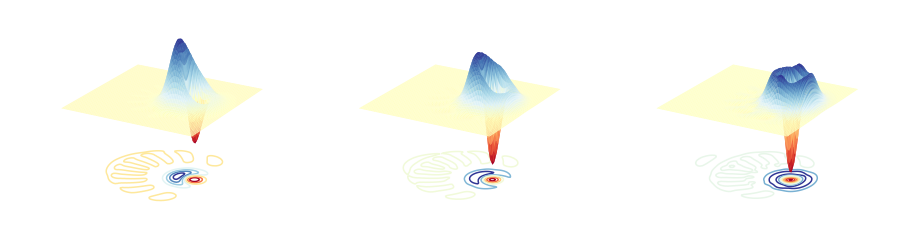

In [16]:
orig_cmap = cm.RdYlBu
shifted_cmap1 = shiftedColorMap(orig_cmap, midpoint=1-(W_filter1.max()/(W_filter1.max()-W_filter1.min())), name='shifted')
#shifted_cmap1 = shiftedColorMap(orig_cmap, midpoint=0, name='shifted')

shifted_cmap2 = shiftedColorMap(orig_cmap, midpoint=1-(W_filter2.max()/(W_filter2.max()-W_filter2.min())), name='shifted')
#shifted_cmap2 = shiftedColorMap(orig_cmap, midpoint=0, name='shifted')

shifted_cmap3 = shiftedColorMap(orig_cmap, midpoint=1-(W_filter3.max()/(W_filter3.max()-W_filter3.min())), name='shifted')

fig = plt.figure(figsize=(16,4))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
#ax = fig.add_subplot(2, 2, 2)
#p = ax.contourf(X, Y, W_filter1, 20, cmap=cm.RdBu)
#cb = fig.colorbar(p, shrink = 0.7)
ax1 = fig.add_subplot(1,3,1, projection='3d')
p = ax1.plot_surface(X, Y, W_filter1, rstride=1,cstride=1, cmap=shifted_cmap1, linewidth=0.5)

ax1.contour(X, Y, W_filter1, cmap=shifted_cmap1, linestyles="solid", offset=-0.35)
#ax1.contour(X, Y, W_filter1, zdir='y', cmap=cm.bwr, offset=3.5)
#ax1.contour(X, Y, W_filter1, zdir='x', cmap=cm.bwr, offset=-4)
plt.axis('off')
plt.subplots_adjust(wspace=0)
#cb = fig.colorbar(p,shrink = 0.4)
#plt.title('Wigner function final state1')
#fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
#ax = fig.add_subplot(2, 2, 2)
#p = ax.contourf(X, Y, W_filter2, 20, cmap=cm.RdBu)
#cb = fig.colorbar(p, shrink = 0.7)
ax2 = fig.add_subplot(1, 3, 2, sharey=ax1,sharez=ax1, sharex=ax1, projection='3d')
p = ax2.plot_surface(X, Y, W_filter2, rstride=1, cstride=1, cmap=shifted_cmap2, linewidth=0.5)
ax2.contour(X, Y, W_filter2, cmap=shifted_cmap2,  linestyles="solid", offset=-0.35)
#ax2.contour(X, Y, W_filter2, [0,1,1.5], zdir='y', cmap=cm.bwr, offset=4)
#ax2.contour(X, Y, W_filter2, zdir='x',cmap=cm.bwr, offset=-4)
#ax2.set_position([0.1,0.11,1,1])
#cb = fig.colorbar(p,shrink = 0.4)
plt.axis('off')
plt.subplots_adjust(wspace=0)
#plt.title('Wigner function final state2')

#fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
#ax = fig.add_subplot(2, 2, 2)
#p = ax.contourf(X, Y, W_filter3, 20, cmap=cm.RdBu)
#cb = fig.colorbar(p, shrink = 0.7)


# surface_plot with color grading and color bar


ax3 = fig.add_subplot(1,3,3,sharey=ax1, sharez=ax1, sharex=ax1, projection='3d')
p = ax3.plot_surface(X, Y, W_filter3, rstride=1, cstride=1, cmap=shifted_cmap3, linewidth=0.5)
ax3.contour(X, Y, W_filter3, cmap=shifted_cmap3, linestyles="solid", offset=-0.35)
#ax3.contour(X, Y, W_filter3, [0,1,1.5],zdir='y', cmap=cm.bwr, offset=4)
#ax3.contour(X, Y, W_filter3, zdir='x', cmap=cm.bwr, offset=-4)
#ax3.set_position([-1,1,0.2,0.2])
#cb = fig.colorbar(p,shrink = 0.6)
#cb.xtics(fontsize=12)
#plt.title('Wigner function final state3')
plt.axis('off')
#plt.subplots_adjust(left=0,wspace=0)
plt.show()


In [17]:
(W_filter1.max()/(W_filter1.max()-W_filter1.min()))

0.6075615338064307

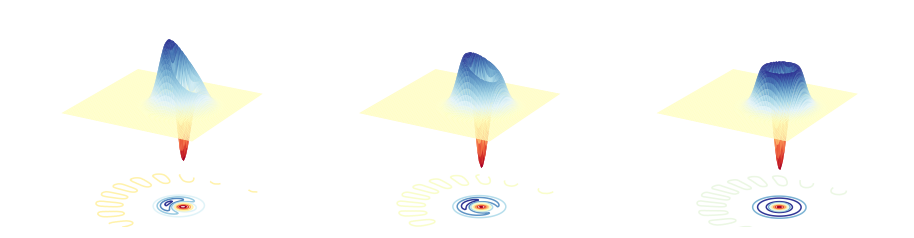

In [18]:
orig_cmap = cm.RdYlBu
shifted_cmap1 = shiftedColorMap(orig_cmap, midpoint=1-(W_eta1.max()/(W_eta1.max()-W_eta1.min())), name='shifted')
#shifted_cmap1 = shiftedColorMap(orig_cmap, midpoint=0, name='shifted')

shifted_cmap2 = shiftedColorMap(orig_cmap, midpoint=1-(W_eta2.max()/(W_eta2.max()-W_eta2.min())), name='shifted')
#shifted_cmap2 = shiftedColorMap(orig_cmap, midpoint=0, name='shifted')

shifted_cmap3 = shiftedColorMap(orig_cmap, midpoint=1-(W_eta3.max()/(W_eta3.max()-W_eta3.min())), name='shifted')

fig = plt.figure(figsize=(16,4))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
#ax = fig.add_subplot(2, 2, 2)
#p = ax.contourf(X, Y, W_filter1, 20, cmap=cm.RdBu)
#cb = fig.colorbar(p, shrink = 0.7)
ax1 = fig.add_subplot(1,3,1, projection='3d')
p = ax1.plot_surface(X, Y, W_eta1, rstride=1,cstride=1, cmap=shifted_cmap1, linewidth=0.5)

ax1.contour(X, Y, W_eta1, cmap=shifted_cmap1, linestyles="solid", offset=-0.35)
#ax1.contour(X, Y, W_filter1, zdir='y', cmap=cm.bwr, offset=3.5)
#ax1.contour(X, Y, W_filter1, zdir='x', cmap=cm.bwr, offset=-4)
plt.axis('off')
plt.subplots_adjust(wspace=0)
#cb = fig.colorbar(p,shrink = 0.4)
#plt.title('Wigner function final state1')
#fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
#ax = fig.add_subplot(2, 2, 2)
#p = ax.contourf(X, Y, W_filter2, 20, cmap=cm.RdBu)
#cb = fig.colorbar(p, shrink = 0.7)
ax2 = fig.add_subplot(1, 3, 2, sharey=ax1,sharez=ax1, sharex=ax1, projection='3d')
p = ax2.plot_surface(X, Y, W_eta2, rstride=1, cstride=1, cmap=shifted_cmap2, linewidth=0.5)
ax2.contour(X, Y, W_eta2, cmap=shifted_cmap2,  linestyles="solid", offset=-0.35)
#ax2.contour(X, Y, W_filter2, [0,1,1.5], zdir='y', cmap=cm.bwr, offset=4)
#ax2.contour(X, Y, W_filter2, zdir='x',cmap=cm.bwr, offset=-4)
#ax2.set_position([0.1,0.11,1,1])
#cb = fig.colorbar(p,shrink = 0.4)
plt.axis('off')
plt.subplots_adjust(wspace=0)
#plt.title('Wigner function final state2')

#fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
#ax = fig.add_subplot(2, 2, 2)
#p = ax.contourf(X, Y, W_filter3, 20, cmap=cm.RdBu)
#cb = fig.colorbar(p, shrink = 0.7)


# surface_plot with color grading and color bar


ax3 = fig.add_subplot(1,3,3,sharey=ax1, sharez=ax1, sharex=ax1, projection='3d')
p = ax3.plot_surface(X, Y, W_eta3, rstride=1, cstride=1, cmap=shifted_cmap3, linewidth=0.5)
ax3.contour(X, Y, W_eta3, cmap=shifted_cmap3, linestyles="solid", offset=-0.35)
#ax3.contour(X, Y, W_filter3, [0,1,1.5],zdir='y', cmap=cm.bwr, offset=4)
#ax3.contour(X, Y, W_filter3, zdir='x', cmap=cm.bwr, offset=-4)
#ax3.set_position([-1,1,0.2,0.2])
#cb = fig.colorbar(p,shrink = 0.6)
#cb.xtics(fontsize=12)
#plt.title('Wigner function final state3')
plt.axis('off')
#plt.subplots_adjust(left=0,wspace=0)
plt.show()


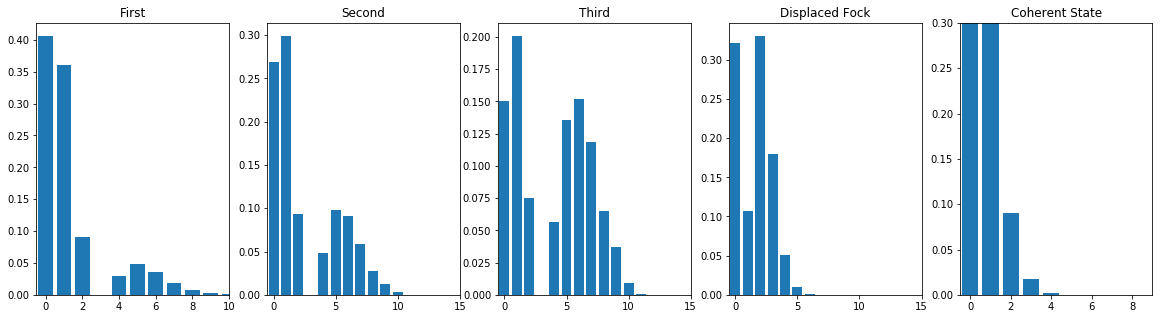

In [24]:
fig, axes = plt.subplots(1, 5, figsize=(20,5))
bar0 = axes[0].bar(range(N_dim), filtered1.diag())

lbl0 = axes[0].set_title("First")

lim0 = axes[0].set_xlim([-.5, 10])
bar1 = axes[1].bar(range(N_dim), filtered2.diag())

lbl1 = axes[1].set_title("Second")

lim1 = axes[1].set_xlim([-.5, 15])

bar2 = axes[2].bar(range(N_dim), filtered3.diag())

lbl2 = axes[2].set_title("Third")

lim2 = axes[2].set_xlim([-.5, 15])

bar3 = axes[3].bar(range(N_dim), D(ket2dm(fock(N_dim,1)),0.752).diag())

lbl3 = axes[3].set_title("Displaced Fock")

lim3 = axes[3].set_xlim([-.5, 15])

bar4 = axes[4].bar(range(N_dim), ket2dm(coherent(N_dim,0.752)).diag())

lbl4 = axes[4].set_title("Coherent State")

limy4= axes[4].set_ylim([0,0.3])

lim4 = axes[4].set_xlim([-0.5, 9])

I am filtering out the | 1 > state
fidelity with squeezed_cat: 0.9724269047759508


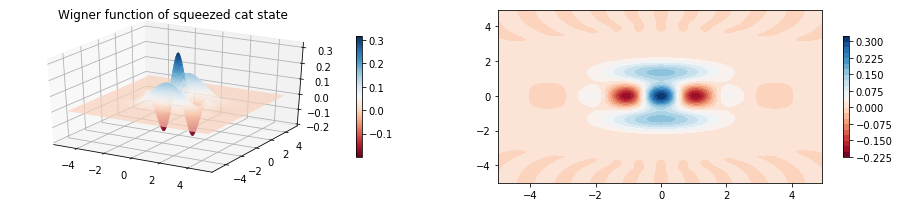

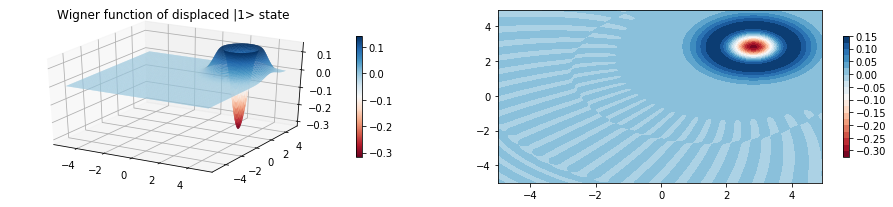

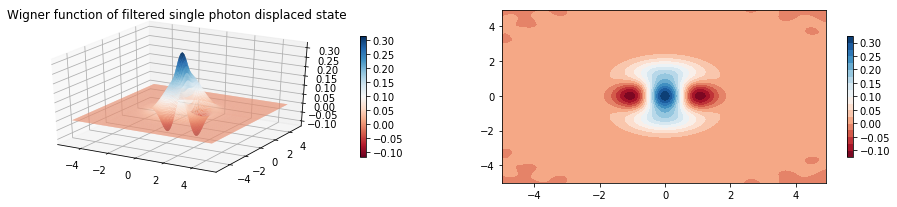

In [12]:
xvec = np.arange(-80.,80.)*5./80
X,Y = np.meshgrid(xvec, xvec)  ##Some plotting params

cat_amp=np.sqrt(5/4)*(1+1j)
#cat_test=Phase(-np.pi/4)*cat_minus(cat_amp)
#Wcat_test=wigner(cat_test,xvec,xvec)
cat_test=Phase(-np.pi/4)*Sq(ket2dm(cat_plus(cat_amp)),.5j)*Phase(-np.pi/4).dag()
Wcat_test=wigner(cat_test,xvec,xvec)

Dfock=D(ket2dm(fock(N_dim,1)),np.sqrt(4)*(1+1j))
W_Dfock=wigner(Dfock,xvec,xvec)

test=Phase(np.pi/4)*D(Fock_Filter_50_50(Dfock,1),np.sqrt(2)*(-1-1j))*Phase(np.pi/4).dag();
W=wigner(test,xvec,xvec);

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, Wcat_test, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Wcat_test, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of squeezed cat state')

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_Dfock, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_Dfock, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of displaced |1> state')

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of filtered single photon displaced state')
fid = fidelity(cat_test,test)
print('fidelity with squeezed_cat:',fid)
plt.show()

I am filtering out the | 5 > state


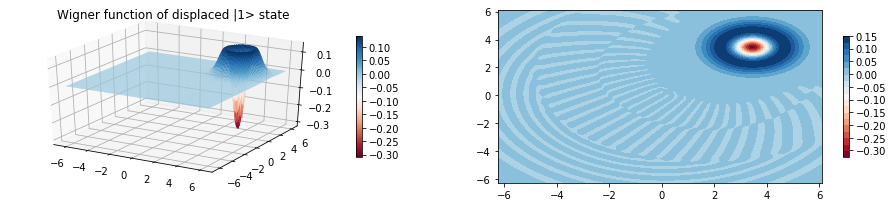

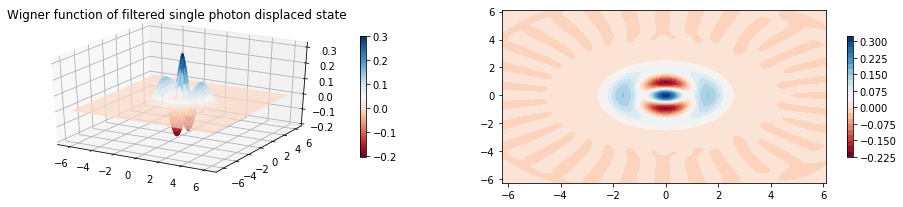

In [13]:
xvec = np.arange(-50.,50.)*5./40
X,Y = np.meshgrid(xvec, xvec)  ##Some plotting params

Dfock=D(ket2dm(fock(N_dim,1)),np.sqrt(6)*(1+1j))
W_Dfock=wigner(Dfock,xvec,xvec)

filter3=Fock_Filter_50_50(Dfock,5)
test=Phase(np.pi/4)*D(filter3,np.sqrt(3)*(-1-1j))*Phase(np.pi/4).dag();
W=wigner(test,xvec,xvec);

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_Dfock, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_Dfock, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of displaced |1> state')

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of filtered single photon displaced state')
plt.show()

I am filtering out the | 1 > state
fidelity with cat: 0.36891122771991797


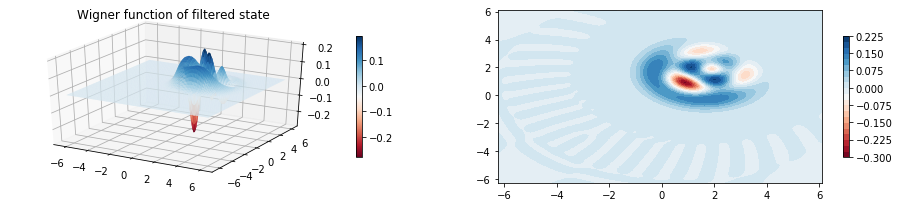

In [14]:
again=Fock_Filter_50_50(filter3,1);
W2=wigner(again,xvec,xvec);

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W2, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of filtered state')
fid = fidelity(cat,second_5050)
print('fidelity with cat:',fid)
plt.show()


In [17]:
eta1=0.58
eta2=0.8
eta3=0.7
n=1
r_sq=.858;
alpha=np.sqrt(n/r_sq)
amp3=alpha/eta;

#amp=np.sqrt(4);
disp_fock=D(ket2dm(fock(N_dim,1)),np.sqrt((amp*amp-n/(eta*eta))))
#dis_fock=D(ket2dm(fock(N_dim,1)),np.sqrt(2-1))
W_dis=wigner(disp_fock,xvec,xvec);


filtered_eta1=Fock_Filter_gen(ket2dm(coherent(N_dim,amp3)),r_sq,n,eta1)
W_eta1=wigner(filtered_eta1,xvec,xvec);

filtered_eta2=Fock_Filter_gen(ket2dm(coherent(N_dim,amp3)),r_sq,n,eta2)
W_eta2=wigner(filtered_eta2,xvec,xvec);

filtered_eta3=Fock_Filter_gen(ket2dm(coherent(N_dim,amp3)),r_sq,n,eta3)
W_eta3=wigner(filtered_eta3,xvec,xvec);


BS has reflectivity 0.858  and I am detecting the | 1 > state, where my detector has efficiency 0.58
BS has reflectivity 0.858  and I am detecting the | 1 > state, where my detector has efficiency 0.8
BS has reflectivity 0.858  and I am detecting the | 1 > state, where my detector has efficiency 0.7


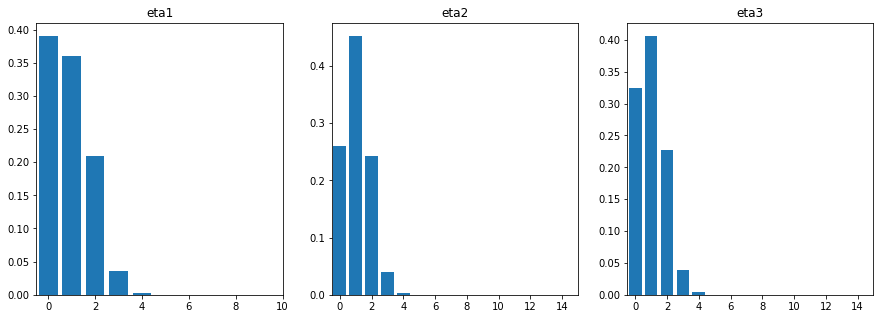

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
bar0 = axes[0].bar(range(N_dim), filtered_eta1.diag())

lbl0 = axes[0].set_title("eta1")

lim0 = axes[0].set_xlim([-.5, 10])
bar1 = axes[1].bar(range(N_dim), filtered_eta2.diag())

lbl1 = axes[1].set_title("eta2")

lim1 = axes[1].set_xlim([-.5, 15])

bar2 = axes[2].bar(range(N_dim), filtered_eta3.diag())

lbl2 = axes[2].set_title("eta3")

lim2 = axes[2].set_xlim([-.5, 15])



In [19]:
filtered_eta1.diag()


array([3.90416042e-01, 3.60393499e-01, 2.09632681e-01, 3.58767563e-02,
       3.44168044e-03, 2.27531455e-04, 1.13715024e-05, 4.28627596e-07,
       1.00647637e-08])

In [60]:
disp_fock=D(ket2dm(fock(N_dim,1)),0.15)
theta = np.arccos(np.sqrt(0.58))
BS1= ((theta)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
new=tensor(fock(N_dim,0)*fock(N_dim,0).dag(),disp_fock)
rho=BS1*new*BS1.dag()
fin=(rho.ptrace(1))/(rho.tr())

In [61]:
fin.diag()

array([4.22025475e-01, 5.63045874e-01, 1.47826789e-02, 1.45126221e-04,
       8.43179904e-07, 3.44206069e-09, 1.06516188e-11, 0.00000000e+00,
       0.00000000e+00])

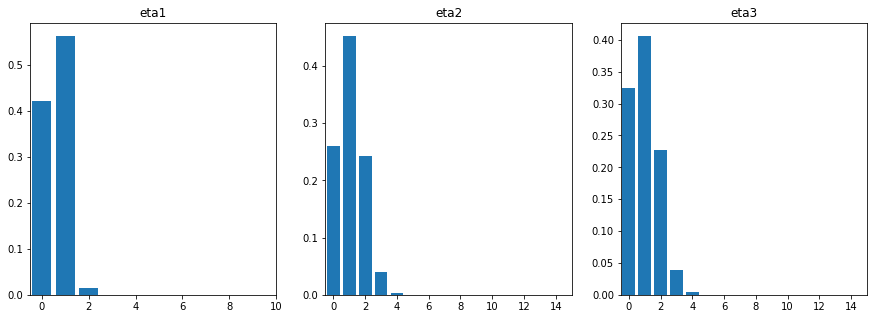

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
bar0 = axes[0].bar(range(N_dim), fin.diag())

lbl0 = axes[0].set_title("eta1")

lim0 = axes[0].set_xlim([-.5, 10])
bar1 = axes[1].bar(range(N_dim), filtered_eta2.diag())

lbl1 = axes[1].set_title("eta2")

lim1 = axes[1].set_xlim([-.5, 15])

bar2 = axes[2].bar(range(N_dim), filtered_eta3.diag())

lbl2 = axes[2].set_title("eta3")

lim2 = axes[2].set_xlim([-.5, 15])